Oriol Cano Marcos
NIU:1599727

# Cas Kaggle
# League of Legends Diamond Ranked Games Dataset 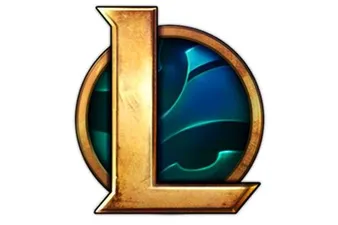

dataset: https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min?resource=download


In [1]:
#llibreries
from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, metrics
import numpy as np
import pandas as pd
%matplotlib notebook
from matplotlib import pyplot as plt
import scipy.stats
import seaborn as sns

# Introducció

Aquest dataset conté dades obtingudes de partides classificatoriers de rang Diamant del joc d'ordinador League of Legends. Aquest joc es basa en una partida on 5 jugadors s'enfronten contra uns altres 5 jugadors els cuals estàn dividits en diferents rols i l'objectiu dels 2 equips és destruir la base enemiga abans que l'altre equip. A part dels jugadors, durant la partida també hi ha altres objectius que ajuden als jugadors que els fan a obtenir or per poder comprar objectes que milloren les estadístiques i experiència que fa pujar de nivell als personatges.

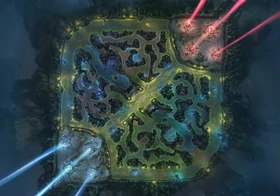


# Lectura del dataset

In [2]:
# Visualitzarem només 3 decimals per mostra
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Funcio per a llegir dades en format csv
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

# Carreguem dataset d'exemple
dataset = load_dataset('LoL_dataset.csv')
data = dataset.values

print("Dimensionalitat de la BBDD:", dataset.shape)
dataset.info()


Dimensionalitat de la BBDD: (9879, 40)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold          

Com podem veure, al dataset tenim dades de la partida com poden ser les morts, els assassinats, la diferència d'or i experiència entre d'altres. Amb la informació que hem obtingut a partir del .info() podem veure que tenim 9879 instàncies i per tant que no tenim cap valor nul, per tant no ens cal fer cap tipus de tractament de nuls.

Veient els diferents atributs que tenim a la base de dades, el millor atribut a predir seria la columna 1, que és un bool que te el valor '1' si la partida la guanya l'equip blau i '0' si la partida la guanya l'equip vermell.
Com que el gameID és solament un identificador de la partida no ens servirà per predir el valor objectiu i per tant no cal utilitzar aquest atribut per predir el valor objectiu. Com que ja tenim atributs que ens donen la diferencia entre dos atributs, un del blau amb el del vermell, podem agafar solament els atributs de l'equip blau per poder treballar amb menys atributs sense perdre informació.

In [3]:
#separacio de l'atribut objectiu (y) amb la resta dels atributs (x)
x = data[:, 2:]
x_blue = data[:, 2:21]
x_red = data[:, 21:]
y = data[:, 1]

print("Dimensionalitat de les entrades X", x.shape)
print("Dimensionalitat de les entrades X", x_blue.shape)
print("Dimensionalitat de les entrades X", x_red.shape)
print("Dimensionalitat de l'atribut Y", y.shape)

Dimensionalitat de les entrades X (9879, 38)
Dimensionalitat de les entrades X (9879, 19)
Dimensionalitat de les entrades X (9879, 19)
Dimensionalitat de l'atribut Y (9879,)


# Estudi de la correlacio i separacio dels atributs

A partir dels meus coneixements sobre el joc podria dir que els atributs més importants a l'hora de predir l'atribut objectiu ha de ser la diferencia de or entre els equips("blueGoldDiff") i la diferencia de experiència ("blueExperienceDiff"). Per comprovar si és cert miraré la correlació que tenen tots els atributs de l'equip blau amb el atribut blueWins.

<IPython.core.display.Javascript object>


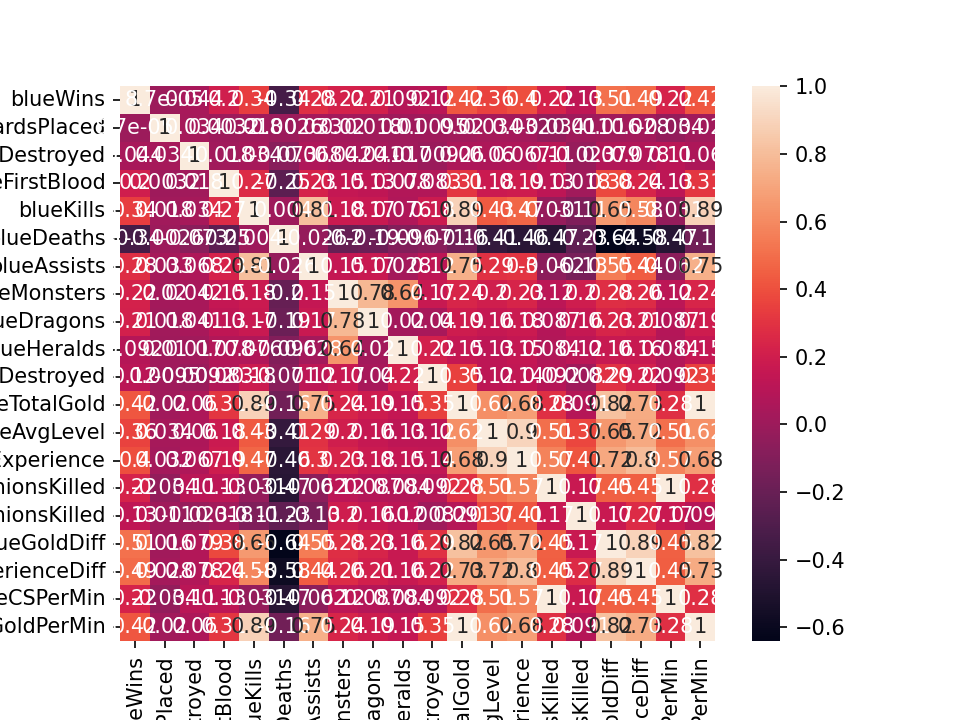

In [4]:

##########
data = pd.read_csv("LoL_dataset.csv", sep=",")
data = data[["blueWins", "blueWardsPlaced", "blueWardsDestroyed", "blueFirstBlood", "blueKills", "blueDeaths", "blueAssists", "blueEliteMonsters", "blueDragons", "blueHeralds", "blueTowersDestroyed", "blueTotalGold", "blueAvgLevel", "blueTotalExperience", "blueTotalMinionsKilled", "blueTotalJungleMinionsKilled", "blueGoldDiff", "blueExperienceDiff", "blueCSPerMin", "blueGoldPerMin"]]
predict = "blueWins"
##########
correlacio = data.corr()
plt.figure()
ax = sns.heatmap(correlacio, annot=True)

<IPython.core.display.Javascript object>


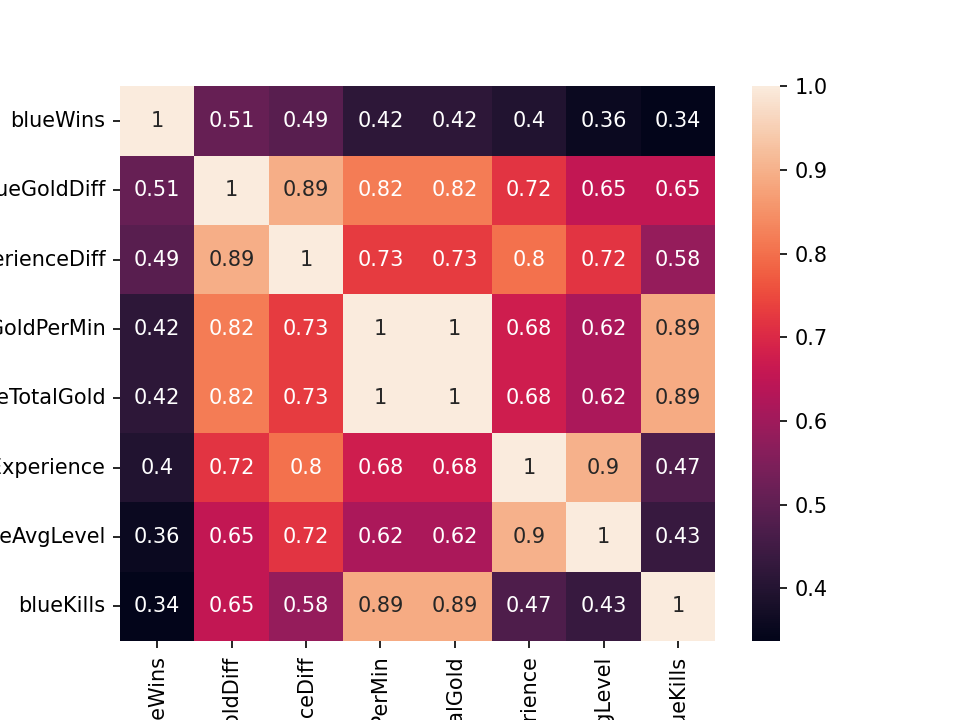

In [5]:
atributs = data[["blueWins", "blueGoldDiff", "blueExperienceDiff", "blueGoldPerMin", "blueTotalGold", "blueTotalExperience", "blueAvgLevel", "blueKills"]]
predir = "blueWins"

correlacio = atributs.corr()
plt.figure()
ax = sns.heatmap(correlacio, annot=True)

Veient els resultats obtinguts de la correlació podem confirmar que els atributs amb més correlació amb obtenir o no la victoria del joc són la diferencia de or (blueGoldDiff) amb un 0.51, la diferencia de experiència (blueExperienceDiff) amb un 0.49 seguit de blueGoldPerMin, blueTotalGold, blueTotalExperience, blueAvgLevel i blueKills.
Vist això utilitzaré aquests atributs per predir l'atribut objectiu.

In [6]:
X = np.array(atributs.drop([predir], 1))
y = np.array(atributs[predir])

C:\Users\oriol\AppData\Local\Temp/ipykernel_4476/2301684255.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = np.array(atributs.drop([predir], 1))


## Divisió train-test

Un cop separat el dataset en els atributs que hem d'utilitzar per la predicció i l'atribut que hem de predir hem de fer una divisió de train i test per utilitzar la divisió de train per entrenar el model i la divisió de test per poder predir el valor objectiu i poder calcular així el valor objectiu i poder calcular la puntuació de la predicció.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

In [8]:
def standarize(x_train):
    mean = x_train.mean(0)
    std = x_train.std(0)
    x_t = x_train - mean[None, :]
    x_t /= std[None, :]
    return x_t

X_train_normalitzat = standarize(X_train)

# Models de predicció

Un cop ja hem mirat quins atributs són més importants a l'hora de determinar si un equip guanya o perd una partida i ja tenim el dataset dividit en train i test ja podem començar a mirar diferents models els quals entrenarem amb la part de train del dataset per després fer les prediccions de la part de test i poder calcular la puntuació de cada model. Un cop calculades les puntuacions podrem arribar a la conclusió de quin dels models és millor per fer les prediccions en aquest cas.

### Regressió logística

In [9]:
regressor = LogisticRegression()
regressor.fit(X_train, y_train)
regressor.score(X_test, y_test)

0.7159244264507423

In [10]:
regressor = LogisticRegression()
regressor.fit(X_train_normalitzat, y_train)
regressor.score(X_test, y_test)

0.720310391363023

### KNN

In [11]:
print("Sense normalitzar: ")
for i in range(2, 50):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, y_train)
    print("n_neighbors", i, ":", neigh.score(X_test, y_test))

Sense normalitzar: 
n_neighbors 2 : 0.6417004048582996
n_neighbors 3 : 0.667004048582996
n_neighbors 4 : 0.6710526315789473
n_neighbors 5 : 0.6791497975708503
n_neighbors 6 : 0.6858974358974359
n_neighbors 7 : 0.6899460188933874
n_neighbors 8 : 0.6953441295546559
n_neighbors 9 : 0.7044534412955465
n_neighbors 10 : 0.7017543859649122
n_neighbors 11 : 0.7095141700404858
n_neighbors 12 : 0.7108636977058029
n_neighbors 13 : 0.7068151147098516
n_neighbors 14 : 0.7122132253711201
n_neighbors 15 : 0.7128879892037787
n_neighbors 16 : 0.7081646423751687
n_neighbors 17 : 0.7125506072874493
n_neighbors 18 : 0.7115384615384616
n_neighbors 19 : 0.7095141700404858
n_neighbors 20 : 0.7142375168690959
n_neighbors 21 : 0.713225371120108
n_neighbors 22 : 0.7122132253711201
n_neighbors 23 : 0.7118758434547908
n_neighbors 24 : 0.7145748987854251
n_neighbors 25 : 0.7142375168690959
n_neighbors 26 : 0.7139001349527665
n_neighbors 27 : 0.7149122807017544
n_neighbors 28 : 0.7169365721997301
n_neighbors 29 : 0

In [12]:
print("Normalitzat: ")
for i in range(2, 50):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train_normalitzat, y_train)
    print("n_neighbors", i, ":", neigh.score(X_test, y_test))

Normalitzat: 
n_neighbors 2 : 0.48819163292847506
n_neighbors 3 : 0.48717948717948717
n_neighbors 4 : 0.48717948717948717
n_neighbors 5 : 0.48717948717948717
n_neighbors 6 : 0.48717948717948717
n_neighbors 7 : 0.48717948717948717
n_neighbors 8 : 0.48717948717948717
n_neighbors 9 : 0.48717948717948717
n_neighbors 10 : 0.48717948717948717
n_neighbors 11 : 0.48717948717948717
n_neighbors 12 : 0.48717948717948717
n_neighbors 13 : 0.48717948717948717
n_neighbors 14 : 0.48717948717948717
n_neighbors 15 : 0.48717948717948717
n_neighbors 16 : 0.48717948717948717
n_neighbors 17 : 0.48717948717948717
n_neighbors 18 : 0.48717948717948717
n_neighbors 19 : 0.48717948717948717
n_neighbors 20 : 0.48717948717948717
n_neighbors 21 : 0.48717948717948717
n_neighbors 22 : 0.48717948717948717
n_neighbors 23 : 0.48717948717948717
n_neighbors 24 : 0.48717948717948717
n_neighbors 25 : 0.48717948717948717
n_neighbors 26 : 0.48717948717948717
n_neighbors 27 : 0.48717948717948717
n_neighbors 28 : 0.4871794871794

Mirant els resultats obtinguts amb diferents valors al paràmetre n_neighbors podem veure que el millor resultat l'obtenim amb el valor 34 amb un 0.719 d'accurracy.

### RandomForest

In [13]:
print("Sense normalitzar:")
for i in range(1, 10):
    print("Max depth", i,": ")
    clf = RandomForestClassifier(max_depth=i, random_state=0)
    clf.fit(X_train, y_train)
    print(clf.score(X_test, y_test))

Sense normalitzar:
Max depth 1 : 
0.708502024291498
Max depth 2 : 
0.7105263157894737
Max depth 3 : 
0.7155870445344129
Max depth 4 : 
0.7155870445344129
Max depth 5 : 
0.7176113360323887
Max depth 6 : 
0.7115384615384616
Max depth 7 : 
0.7182860998650472
Max depth 8 : 
0.7169365721997301
Max depth 9 : 
0.7176113360323887


In [14]:
print("Normalitzat:")
for i in range(1, 10):
    print("Max depth", i,": ")
    clf_normalitzat = RandomForestClassifier(max_depth=i, random_state=0)
    clf_normalitzat.fit(X_train_normalitzat, y_train)
    print(clf_normalitzat.score(X_test, y_test))

Normalitzat:
Max depth 1 : 
0.7115384615384616
Max depth 2 : 
0.7115384615384616
Max depth 3 : 
0.7118758434547908
Max depth 4 : 
0.7118758434547908
Max depth 5 : 
0.7118758434547908
Max depth 6 : 
0.7115384615384616
Max depth 7 : 
0.546221322537112
Max depth 8 : 
0.7125506072874493
Max depth 9 : 
0.7118758434547908


Com podem veure, la profunditat de l'arbre que ens dona una millor puntuació és l'arbre amb una profunditat màxima de 7 en el cas sense normalitzar i amb profunditat màxima de 8 en el normalitzat.

In [15]:
clf = RandomForestClassifier(max_depth=7, random_state=0)
clf.fit(X_train, y_train)
clf_normalitzat = RandomForestClassifier(max_depth=8, random_state=0)
clf_normalitzat.fit(X_train_normalitzat, y_train)
print("Sense normalitzar:",clf.score(X_test, y_test))
print("Normalitzat:", clf_normalitzat.score(X_test, y_test))

Sense normalitzar: 0.7182860998650472
Normalitzat: 0.7125506072874493


### SVM

In [16]:
clf = svm.SVC(kernel='linear') 

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy sense normalitzar:",metrics.accuracy_score(y_test, y_pred))

Accuracy sense normalitzar: 0.7149122807017544


In [17]:
clf = svm.SVC(kernel='linear') 

clf.fit(X_train_normalitzat, y_train)

y_pred = clf.predict(X_test)

print("Accuracy normalitzat:",metrics.accuracy_score(y_test, y_pred))

Accuracy normalitzat: 0.7162618083670715


# Resultats i conclusions

In [18]:
taula = pd.DataFrame(data = [[0.716, 0.72], [0.719, 0.488], [0.718, 0.712], [0.715, 0.716]], columns=['Accuracy sense dades normalitzades', 'Accuracy amb dades normalitzades'], index=['Regressió logística', 'KNN', 'Random Forest', 'SVM'])
taula

,Accuracy sense dades normalitzades,Accuracy amb dades normalitzades
Regressió logística,0.716,0.720
KNN,0.719,0.488
Random Forest,0.718,0.712
SVM,0.715,0.716


A partir de tots els resultats obtinguts hem pogut veure que els atributs més importants a l'hora de guanyar o perdre una partida són principalment la diferènciaa d'or i la diferència d'experiència. A partir d'utilitzar aquests i alguns atributs més per fer les prediccions hem pogut observar que el model que ens dona una millor accuracy i per tant el model més precís dels que hem utilitzat és la regressió logística amb dades normalitzades que ens dona un accuracy de 0.72, tot i que la majoria dels models utilitzats tenen una accuracy molt semblant.